In [ ]:
import numpy as np
import pandas as pd
import anndata as ad
from pprint import pprint as pp
import custom_func as pc 
import umap as um
import cyclops as cc
import COFE.analyse
from SyntheticData import *

/opt/anaconda3/envs/oldenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1: Prepare Synthetic Data

In [3]:
## Define dataset parameters
n_genes = 2000     # Total number of genes/transcripts in the synthetic dataset
n_samples = 200    # Number of samples used for training
n_test = 25        # Number of samples used for testing

# Initialize the data generator with the defined parameters
data = SyntheticData(n_genes, n_samples + n_test)

# Define oscillation frequencies in radians/hour
# Here, we are specifying a single rhythmic group.
data.oscillatory_groups(1)

# Generate the synthetic dataset
# - normal_dist_times=False: Times are uniformly spaced instead of normally distributed
# - rhy_frac=0.1: 10% of genes are rhythmic
X_synthetic, group_info, _ = data.generate_data(normal_dist_times=False, 
                                                    rhy_frac=0.1)

# Extract true sample times (used for validation later)
time = data.t  # True sample times that COFE does not "see" during analysis

# Add noise to the dataset
# st_dev=0.25 adds Gaussian noise with a standard deviation of 0.25
X = data.corrupt(X_synthetic, st_dev=0.25)

## Split the dataset into training and testing sets
X_train = X[:, :n_samples].copy()  # Training data
X_test = X[:, n_samples:].copy()   # Testing data

### Step 2: Preprocess Synthetic Data  

In [4]:
# Standardize the dataset for analysis
# Z_train, Z_test: Standardized training and testing data
# features: Gene features used in analysis
# feature_std: Standard deviations of features for scaling
Z_train, Z_test, features, feature_std = COFE.analyse.preprocess_data(
    X_train, X_test, np.arange(n_genes), feature_dim='row', scale=True)

### Step 3: Run CYCLOPs on Synthetic Data

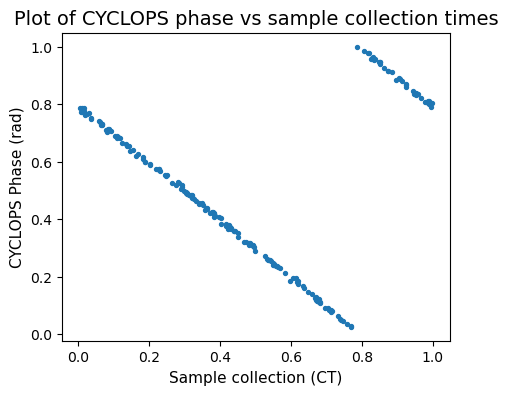

In [5]:
cyclops_result = cc.cyclops(Z_train)
cyclops_result.train_model()
cyclops_result.plot_true_vs_predicted_phase(true_phase=time[:n_samples], data=Z_train)

In [7]:
COFE.analyse.calculate_mape(cyclops_result.predict_phase(Z_train),time[:n_samples], period=1)[1]

0.0041138830866085385

### Step 4: Open Real Data

In [10]:
adata

AnnData object with n_obs × n_vars = 1096 × 40614
    obs: 'study', 'time', 'outlier', 'Sex', 'Light', 'Age (weeks)', 'Sequencing Type', 'Inferred Sequencing Type', 'Note'
    var: 'Symbol'
    obsm: 'centered_study_log_full', 'centered_study_log_full_pydeseq2', 'centered_study_log_small', 'small_reduction'
    layers: 'centered_study_log_full', 'centered_study_log_full_pydeseq2', 'deseq2_norm', 'log_trasformed', 'log_trasformed_deseq2', 'not_normalized'

In [46]:
path = '/Users/maksimsgolubovics/Studienprojekt/Studienprojekt/Study Project/mouse_liver'
adata = ad.read_h5ad(path)
true_phase = adata.obs['time'].to_numpy()/24
cs_df = adata.obsm['centered_study_log_small']


In [47]:
cs_df

,ENSMUSG00000085087,ENSMUSG00000091192,ENSMUSG00000085767,ENSMUSG00000087612,ENSMUSG00000075514,ENSMUSG00000086657,ENSMUSG00000086728,ENSMUSG00000086914,ENSMUSG00000089810,ENSMUSG00000097320,...,ENSMUSG00000000628,ENSMUSG00000021643,ENSMUSG00000099242,ENSMUSG00000099055,ENSMUSG00000098330,ENSMUSG00000051359,ENSMUSG00000031901,ENSMUSG00000115219,ENSMUSG00000024810,ENSMUSG00000063488
GSM2046160,0.031666,0.105557,0.052562,-0.069727,-0.037316,0.070372,-0.011189,-0.010215,0.008647,0.036198,...,0.148917,0.043549,0.153818,0.089851,-0.199848,0.169529,0.187840,0.080364,0.039074,0.060173
GSM2046184,0.090323,-0.164406,0.137431,-0.107048,-0.319325,-0.122910,0.081511,-0.134137,-0.028685,0.008818,...,0.244637,-0.047298,0.104450,-0.077401,0.337157,0.092969,0.105042,0.071095,0.096295,-0.022728
GSM2046157,0.116786,0.089724,-0.033826,-0.061663,0.179787,0.003401,0.168988,0.222311,0.078518,-0.022093,...,0.076664,0.066903,0.230507,-0.122732,0.113758,0.000455,-0.094263,-0.014713,-0.003493,0.039788
GSM2046183,0.064660,0.097689,0.081732,0.282669,-0.049975,-0.107074,-0.002822,-0.075484,0.027385,-0.004569,...,-0.022831,-0.006598,0.099645,-0.077792,0.321273,-0.110847,-0.042278,0.047543,-0.094325,0.025496
GSM2046155,-0.011945,0.230203,0.246437,0.135068,-0.083717,0.115414,0.010246,-0.152943,0.012046,0.003473,...,-0.013179,-0.022021,0.187515,0.075380,0.591091,0.088073,0.123574,0.086462,-0.127701,0.063218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,-0.836609,-0.740234,0.048631,0.035034,0.116078,-0.004553,0.064722,-0.003611,0.150172,0.068574,...,0.251991,0.034718,-0.304884,-0.057989,0.538807,-0.313718,-0.057267,0.008365,0.042199,0.020784
GSM6610724,0.120704,-0.740234,0.024070,0.176556,0.115831,0.070243,0.007028,-0.002921,0.032453,0.074524,...,-0.000690,0.020524,0.330511,0.379705,-0.262752,0.062453,0.043400,-0.014638,0.021352,-0.013097
GSM6610752,-0.098360,-0.740234,0.126512,0.013784,-0.077781,0.132756,-0.036116,-0.015444,-0.056856,-0.007517,...,-0.071026,0.031125,-0.204506,-0.192189,-0.275214,0.142839,0.102482,0.005685,0.043053,0.178153
GSM6610726,0.272176,0.487228,0.125070,0.129666,0.089781,-0.061963,0.023936,0.016026,0.117004,0.139363,...,0.042415,-0.115031,0.332226,0.486322,0.317066,0.080635,0.033505,-0.084202,0.002219,-0.023146


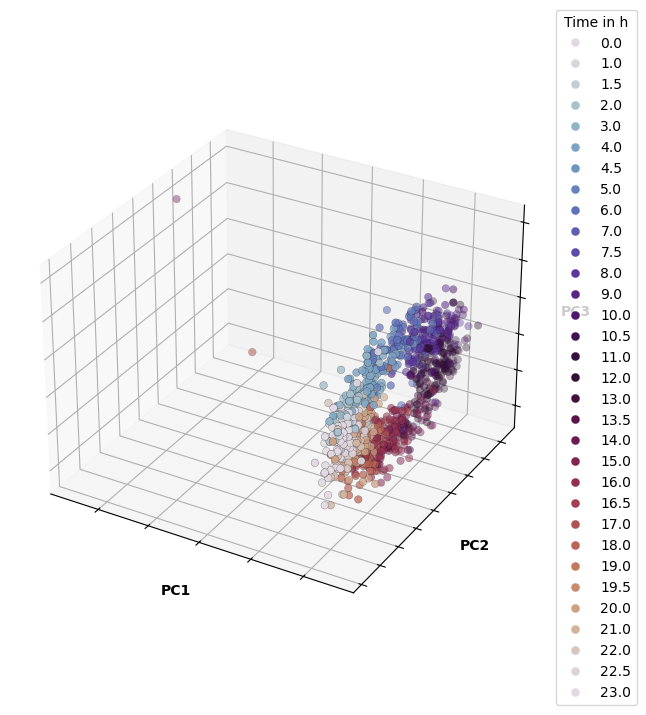

In [13]:
pc.principal_component_3d_timesample(data=cs_df, label='Time in h', c_map='twilight')

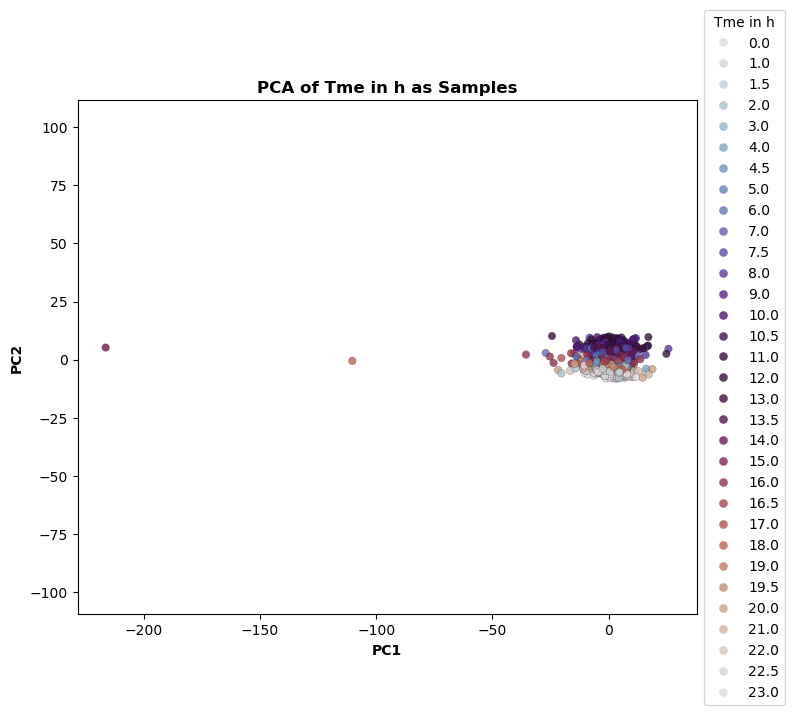

In [11]:
pc.principal_component_2d_timesample(data=cs_df, label='Tme in h', c_map='twilight')

### Step 5: Preprocess Real Data 

In [64]:
X_train_1 = cs_df.to_numpy()

Z_train_1, Z_test_1, features_1, feature_std_1 = COFE.analyse.preprocess_data(X_train_1, X_test=None,  
                                                                      features=cs_df.columns, feature_dim='col',
                                                                      mean_threshold=-1, scaling_threshold=4)

Z_train_1.shape

(1096, 1409)

### CYCLOPs full dataset

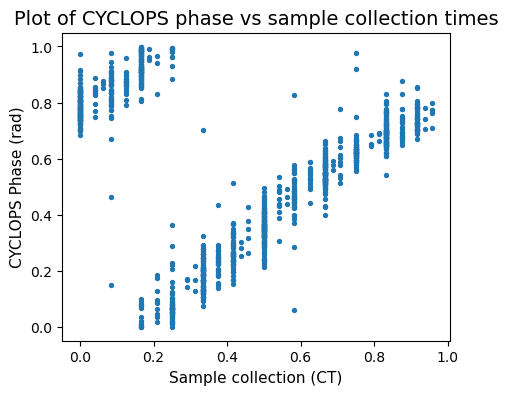

In [65]:
cyclops_result = cc.cyclops(Z_train_1)
cyclops_result.train_model(best_of=100, epochs=1000, momentum=0.4)
cyclops_result.plot_true_vs_predicted_phase(true_phase=true_phase, data=Z_train_1)

In [69]:
COFE.analyse.calculate_mape(cyclops_result.predict_phase(Z_train_1),true_phase, period=1)[1]*24

1.0311161279678336

### CYCLOPs first 5 studies 

In [71]:
study = adata.obs[adata.obs['study'].isin(['Abe22', 'Acosta-Rodríguez22A', 'Acosta-Rodríguez22B', 'Astafev23','Yang16A'])]['study']
X_train = cs_df.loc[study.index].to_numpy()

Z_train, Z_test, features, feature_std = COFE.analyse.preprocess_data(X_train, X_test=None,  
                                                                      features=cs_df.columns, feature_dim='col',
                                                                      mean_threshold=-1, scaling_threshold=4)

Z_train.shape

(101, 1616)

In [72]:
true_phase_study = adata.obs['time'].loc[study.index].to_numpy()/24

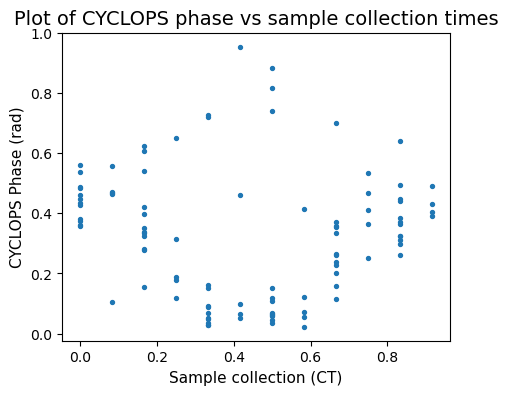

In [73]:
cyclops_result_2 = cc.cyclops(Z_train)
cyclops_result_2.train_model(best_of=60, epochs=400, momentum=0.4)
cyclops_result_2.plot_true_vs_predicted_phase(true_phase=true_phase_study, data=Z_train)

In [75]:
COFE.analyse.calculate_mape(cyclops_result_2.predict_phase(Z_train),true_phase_study, period=1)[1]*24

2.5820444488525407